# **Block 5: Blending with NWP**
In this final block, we will show another pysteps functionality: blending with NWP. This notebook shows the solution for the blending excercices.

In this example, we show how to blend an (ensemble) nowcast with an NWP rainfall forecast using three different blending methods implemented in pysteps. Examples of the blending methods are described in [Linear Blending](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_linear_blending.html#sphx-glr-auto-examples-plot-linear-blending-py) and [STEPS blending](https://pysteps.readthedocs.io/en/latest/auto_examples/blended_forecast.html#sphx-glr-auto-examples-blended-forecast-py). We will loosely follow these examples, but for a different dataset from RMI Belgium, which asks for a few more pre-processing steps.

Let's first run the first notebook (block 1) to install pysteps and configure it. This is needed because Colab notebooks are independent of each other and it's not possible to save the state of a notebook and use it in another one.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the previous notebook to configure the environment
%run block_01_setup_conda-colab.ipynb

/content/mnt/MyDrive/Colab Notebooks
✨🍰✨ Everything looks OK!
Installed conda-colab in 1.024 seconds

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for:

## Load the example dataset

Now that we have initialized the notebook, let's import the example RMI radar and NWP dataset. To run this, the [pysteps-nwp-importers](https://github.com/pySTEPS/pysteps-nwp-importers) plugin needs to be installed in addition to the pysteps installation. The example RMI and NWP data is from a case on 4 July 2021 from 16:05 until 18:00 UTC.

In [2]:
# Install the nwp importers plugin
!pip install git+https://github.com/pySTEPS/pysteps-nwp-importers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pySTEPS/pysteps-nwp-importers to /tmp/pip-req-build-zpamrxgg
  Running command git clone -q https://github.com/pySTEPS/pysteps-nwp-importers /tmp/pip-req-build-zpamrxgg
     |████████████████████████████████| 845 kB 25.6 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 141 kB 75.1 MB/s 
     |████████████████████████████████| 596 kB 63.8 MB/s 
     |████████████████████████████████| 11.3 MB 46.4 MB/s 
     |████████████████████████████████| 500 kB 57.2 MB/s 
  Created wheel for pysteps-nwp-importers: filename=pysteps_nwp_importers-0.1-py2.py3-none-any.whl size=15537 sha256=393ef5deda05c3a54e9d6753ac4614b81d0b2eaf4d63d51c0a61a45b5d9e7abc
  Stored in directory: /tmp/pip-ephem-wheel-cache-j93ay0tf/wh

In [3]:
# Reconfigure and reload the pystepsrc file
from pysteps.datasets import create_default_pystepsrc
config_file_path = create_default_pystepsrc("pysteps_data")
import pysteps
_ = pysteps.load_config_file(config_file_path, verbose=True)

Pysteps configuration file found at: /root/.pysteps/pystepsrc



In [4]:
import datetime
import numpy as np
import pysteps_nwp_importers

In [5]:
# Selected case
date_radar = datetime.datetime.strptime("202107041605", "%Y%m%d%H%M")
# The last NWP forecast was issued at 12:00 UTC
date_nwp = datetime.datetime.strptime("202107041200", "%Y%m%d%H%M")
radar_data_source = pysteps.rcparams.data_sources["rmi"]
nwp_data_source = pysteps.rcparams.data_sources["rmi_nwp"]

# Get the paths from the pystepsrc file
root_path = radar_data_source["root_path"]
path_fmt = radar_data_source["path_fmt"]
#fn_pattern = radar_data_source["fn_pattern"]
fn_pattern = "%Y%m%d%H%M00.rad.best.comp.rate.qpe"
fn_ext = radar_data_source["fn_ext"]
importer_name = radar_data_source["importer"]
importer_kwargs = radar_data_source["importer_kwargs"]
timestep = radar_data_source["timestep"]

# Find the radar files in the archive
fns = pysteps.io.find_by_date(
    date_radar, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=2, num_next_files=23,
)

# Read the radar composites
importer = pysteps.io.get_method(importer_name, "importer")
radar_precip_full, _, radar_metadata = pysteps.io.read_timeseries(fns, importer, **importer_kwargs)
print(radar_metadata)
# Keep the first three time steps as the input data for the nowcasts and the 
# remaining time steps as observations for comparison with the forecast
radar_precip = radar_precip_full[0:3]
precip_obs = radar_precip_full[3:]
precip_obs_metadata = radar_metadata.copy()


# Import the NWP data
filename = os.path.join(
    nwp_data_source["root_path"],
    datetime.datetime.strftime(date_nwp, nwp_data_source["path_fmt"]),
    datetime.datetime.strftime(date_nwp, nwp_data_source["fn_pattern"])
    + "."
    + nwp_data_source["fn_ext"],
)

nwp_precip, _, nwp_metadata = pysteps_nwp_importers.importer_rmi_nwp.import_rmi_nwp(filename)
print(nwp_metadata)

# Make sure the units are in mm/h (note that the linear blending code also does 
# this automatically for you)
converter = pysteps.utils.get_method("mm/h")
radar_precip, radar_metadata = converter(radar_precip, radar_metadata)
precip_obs, precip_obs_metadata = converter(precip_obs, precip_obs_metadata)
nwp_precip, nwp_metadata = converter(nwp_precip, nwp_metadata)

{'projection': '+proj=lcc +lat_1=49.83333333333334 +lat_2=51.16666666666666 +lat_0=50.797815 +lon_0=4.359215833333333 +x_0=649328 +y_0=665262 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs ', 'll_lon': -0.2666973996088157, 'll_lat': 47.41679117656605, 'ur_lon': 9.664159875778674, 'ur_lat': 53.69199685747096, 'x1': 300000.00000639464, 'y1': 300000.0001025078, 'x2': 999999.9999935813, 'y2': 1000000.0000994031, 'xpixelsize': 1000.0, 'ypixelsize': 1000.0, 'cartesian_unit': 'm', 'yorigin': 'upper', 'institution': 'Odyssey datacentre', 'accutime': 5.0, 'unit': 'mm/h', 'transform': None, 'zerovalue': 0.0, 'threshold': 0.04034535586833954, 'timestamps': array([datetime.datetime(2021, 7, 4, 15, 55),
       datetime.datetime(2021, 7, 4, 16, 0),
       datetime.datetime(2021, 7, 4, 16, 5),
       datetime.datetime(2021, 7, 4, 16, 10),
       datetime.datetime(2021, 7, 4, 16, 15),
       datetime.datetime(2021, 7, 4, 16, 20),
       datetime.datetime(2021, 7, 4, 16, 25),
       datetime.dat

## Visualize the data
Plot the radar rainfall field and the first time step of the NWP forecast.

For the initial time step (t=0), the NWP rainfall forecast is quite different
from the observed radar rainfall. Ideally, the blended forecast will give a high weight to the nowcasts for the first lead times. The NWP forecast might still contain useful information for longer lead times. We will see if that is true in the subsequent part of this exercise. 

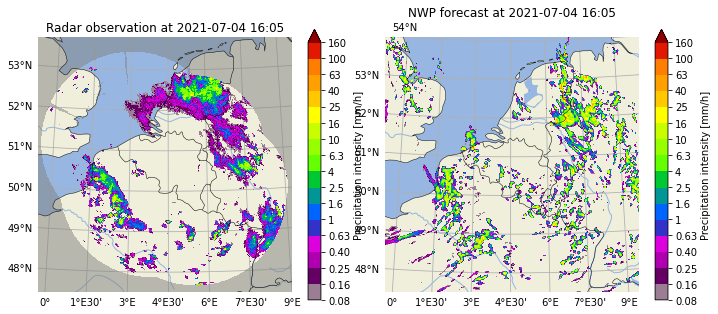

In [6]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

date_str = datetime.datetime.strftime(date_radar, "%Y-%m-%d %H:%M")

map_kwargs = {"drawlonlatlines": True}
plt.figure(figsize=(10, 5))
plt.subplot(121)

# First plot the radar data
plot_precip_field(
    radar_precip[-1, :, :],
    geodata=radar_metadata,
    title=f"Radar observation at {date_str}",
    colorscale="pysteps", 
    map_kwargs=map_kwargs,
)

# Then plot the NWP data
plt.subplot(122)
plot_precip_field(
    nwp_precip[0, :, :], 
    geodata=nwp_metadata, 
    title=f"NWP forecast at {date_str}", 
    colorscale="pysteps", 
    map_kwargs=map_kwargs
)
plt.tight_layout()
plt.show()

## Reproject NWP data on radar grid
You may have observed that the extent and grid cell size of the NWP forecast is somehwat different than those of the radar observations. A difference with the gallery examples in [Linear Blending](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_linear_blending.html#sphx-glr-auto-examples-plot-linear-blending-py) and [STEPS blending](https://pysteps.readthedocs.io/en/latest/auto_examples/blended_forecast.html#sphx-glr-auto-examples-blended-forecast-py) is that the RMI NWP rainfall forecasts are projected on a different, coarser grid than the RMI radar data. Prior to blending, we will have to reproject the NWP data on the radar grid.

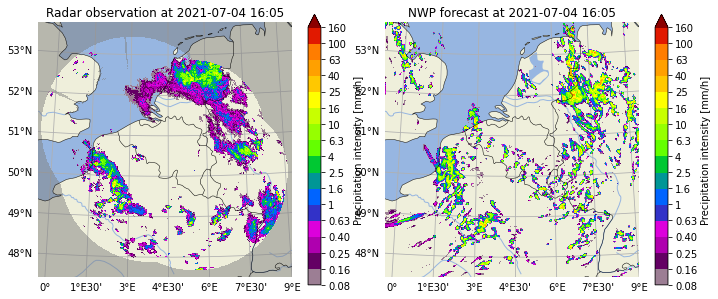

In [7]:
# Reproject the projection of the nwp data to the projection of the radar data
nwp_precip, nwp_metadata = pysteps.utils.reproject_grids(src_array=nwp_precip, dst_array=radar_precip[-1, :, :], metadata_src=nwp_metadata, metadata_dst=radar_metadata)

# Let's plot it again to see the difference
plt.figure(figsize=(10, 5))
plt.subplot(121)

# First plot the radar data
plot_precip_field(
    radar_precip[-1, :, :],
    geodata=radar_metadata,
    title=f"Radar observation at {date_str}",
    colorscale="pysteps", 
    map_kwargs=map_kwargs,
)

# Then plot the NWP data
plt.subplot(122)
plot_precip_field(
    nwp_precip[0, :, :], 
    geodata=nwp_metadata, 
    title=f"NWP forecast at {date_str}", 
    colorscale="pysteps", 
    map_kwargs=map_kwargs
)
plt.tight_layout()
plt.show()

## Linear blending
### Pre-processing steps
The pre-processing steps prior to the linear blending consist of thresholding the data, optional data transformations and the estimation of the velocity field for the radar rainfall nowcast (see also block 2 and 3).

In [8]:
# Threshold the data (here: simple threshold of 0.1 mm/h used)
radar_precip[radar_precip < 0.1] = 0.0
nwp_precip[nwp_precip < 0.1] = 0.0

# Only keep the NWP forecasts from 2021-07-04 16:10 onwards, because the first
# forecast lead time starts at 16:10 if the issue time is 16:05.
nwp_precip_slice = nwp_precip[1:].copy()

# Transform the radar data to dB - this transformation is useful for the motion
# field estimation and the subsequent nowcasts. The NWP forecast is not
# transformed, because the linear blending code sets everything back in mm/h
# after the nowcast.
transformer = pysteps.utils.get_method("dB")
radar_precip, radar_metadata = transformer(radar_precip, 
                                           radar_metadata, 
                                           threshold=0.1,
                                           )

# Determine the velocity field
oflow_method = pysteps.motion.get_method("lucaskanade")
velocity_radar = oflow_method(radar_precip)

### The linear blending forecast


In [9]:
precip_blended_linear = pysteps.blending.linear_blending.forecast(
    precip=radar_precip[-1, :, :],
    precip_metadata=radar_metadata,
    velocity=velocity_radar,
    timesteps=23,
    timestep=5,
    nowcast_method="extrapolation",  # simple advection nowcast
    precip_nwp=nwp_precip_slice,
    precip_nwp_metadata=nwp_metadata,
    start_blending=30,  # in minutes (this is an arbritrary choice)
    end_blending=90,  # in minutes (this is an arbritrary choice)
)

### Visualize the output and give an indication of the skill

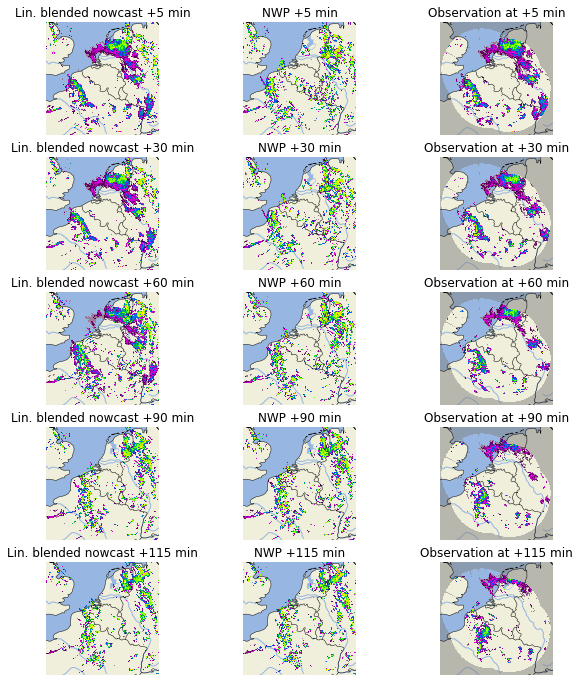

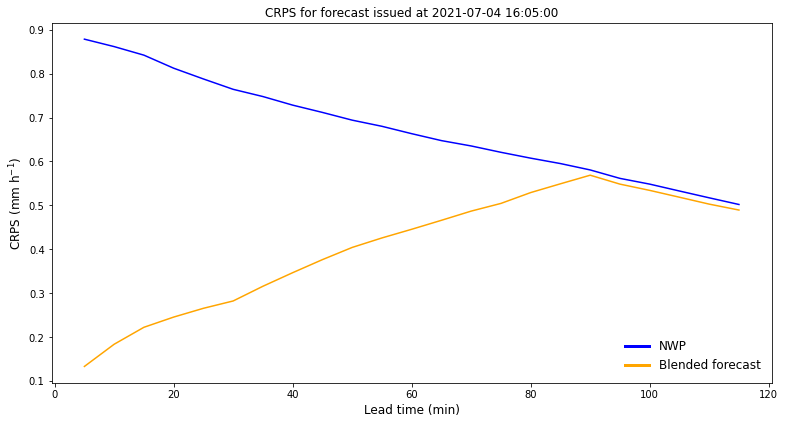

In [10]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 12))

leadtimes_min = [5, 30, 60, 90, 115]
n_leadtimes = len(leadtimes_min)
for n, leadtime in enumerate(leadtimes_min):

    # Nowcast with blending into NWP
    plt.subplot(n_leadtimes, 3, n * 3 + 1)
    plot_precip_field(
        precip_blended_linear[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Lin. blended nowcast +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 3, n * 3 + 2)
    plot_precip_field(
        nwp_precip[int(leadtime / timestep) - 1, :, :],
        geodata=nwp_metadata,
        title=f"NWP +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # The observed rainfall
    plt.subplot(n_leadtimes, 3, n * 3 + 3)
    plot_precip_field(
        precip_obs[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Observation at +{leadtime} min",
        axis="off",
        colorbar=False,
    )
    
# Determine the skill of both forecasts
# We will use the CRPS (but feel free to use any other skill score), as it allows
# us to do tests with ensemble forecasts later on.
# Make an empty list of the CRPS per lead time
CRPS_lt = dict({'blended': [], 'NWP': []})
n_timesteps = 23
for lt in range(n_timesteps):
    CRPS_lt['blended'].append(pysteps.verification.probscores.CRPS(np.stack([precip_blended_linear[lt,:,:]]),precip_obs[lt,:,:]))
    CRPS_lt['NWP'].append(pysteps.verification.probscores.CRPS(np.stack([nwp_precip[lt,:,:]]),precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['NWP'],
    color="blue",
)
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['blended'],
    color="orange",
)

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title(f"CRPS for forecast issued at {date_radar}")

# Set the legend
legend_elements_cmls = [Line2D([0], [0], color='blue', label="NWP", linewidth = 3),
                        Line2D([0], [0], color='orange', label="Blended forecast", linewidth = 3),]

ax1.legend(handles=legend_elements_cmls, loc='lower right', frameon = False, fontsize = 12, ncol = 1)

plt.tight_layout()
plt.show()


# Linear blending with different settings
As you can see, the blending is not yet optimal. The blending with NWP probably takes place too soon and perhaps also the blending rate (the time between start and end of blending) is not right. On the nowcasting side of the forecast we can also make some adjustments by, for example, using a different nowcasting method and by introducing an ensemble forecast. Play a bit around with the forecast settings and see if and how this improves the forecast. 

Below, we show one option where the blending times have been adjusted and a probablistic steps nowcast with 10 ensemble members is used instead of just extrapolation. 

In [11]:
precip_blended_linear = pysteps.blending.linear_blending.forecast(
    precip=radar_precip[:, :, :],
    precip_metadata=radar_metadata,
    velocity=velocity_radar,
    timesteps=23,
    timestep=5,
    nowcast_method="steps",  
    precip_nwp=nwp_precip_slice,
    precip_nwp_metadata=nwp_metadata,
    start_blending=60,  
    end_blending=180,  
    nowcast_kwargs={"R_thr": 0.1, "kmperpixel": 1.0, "timestep": 5, "n_ens_members": 10}
)

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 700x700
km/pixel:         1.0
time step:        5 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     23
ensemble size:            10
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: 0.1
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------


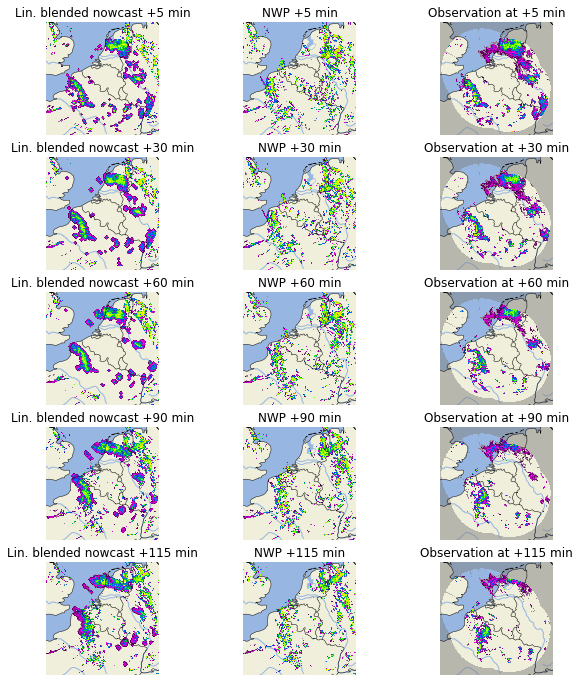

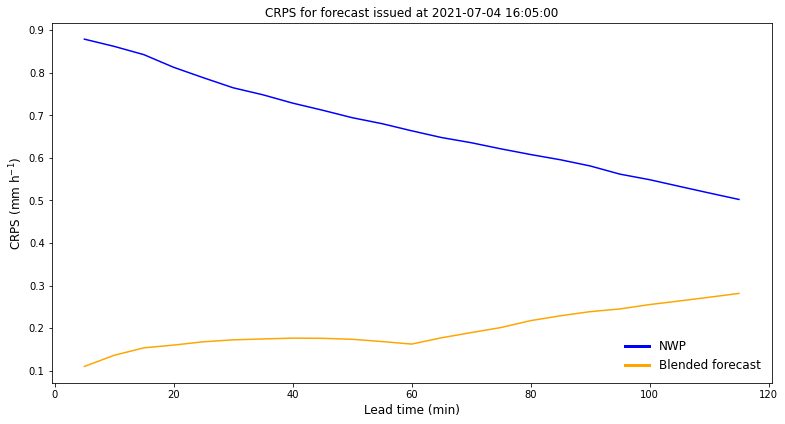

In [12]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 12))

leadtimes_min = [5, 30, 60, 90, 115]
n_leadtimes = len(leadtimes_min)
for n, leadtime in enumerate(leadtimes_min):

    # Nowcast with blending into NWP (only ensemble member 1 is plotted)
    plt.subplot(n_leadtimes, 3, n * 3 + 1)
    plot_precip_field(
        precip_blended_linear[0, int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Lin. blended nowcast +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 3, n * 3 + 2)
    plot_precip_field(
        nwp_precip[int(leadtime / timestep) - 1, :, :],
        geodata=nwp_metadata,
        title=f"NWP +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # The observed rainfall
    plt.subplot(n_leadtimes, 3, n * 3 + 3)
    plot_precip_field(
        precip_obs[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Observation at +{leadtime} min",
        axis="off",
        colorbar=False,
    )
    
# Determine the skill of both forecasts
# We will use the CRPS (but feel free to use any other skill score), as it allows
# us to do tests with ensemble forecasts later on.
# Make an empty list of the CRPS per lead time
CRPS_lt = dict({'blended': [], 'NWP': []})
n_timesteps = 23
for lt in range(n_timesteps):
    CRPS_lt['blended'].append(pysteps.verification.probscores.CRPS(precip_blended_linear[:,lt,:,:],precip_obs[lt,:,:]))
    CRPS_lt['NWP'].append(pysteps.verification.probscores.CRPS(np.stack([nwp_precip[lt,:,:]]),precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['NWP'],
    color="blue",
)
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['blended'],
    color="orange",
)

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title(f"CRPS for forecast issued at {date_radar}")

# Set the legend
legend_elements_cmls = [Line2D([0], [0], color='blue', label="NWP", linewidth = 3),
                        Line2D([0], [0], color='orange', label="Blended forecast", linewidth = 3),]

ax1.legend(handles=legend_elements_cmls, loc='lower right', frameon = False, fontsize = 12, ncol = 1)

plt.tight_layout()
plt.show()


## Salient blending
A disadvantage of simple linear blending is that higher intensity rainfall cells are not preserved, but get smoothed in between the start and end time of the blending procedure. Another option is to use a saliency-based blending method, which focuses more on rainfall intensities over the forecast times. The blended product preserves pixel intensities with time if they are strong enough based on their ranked salience. Saliency is the property of an object to be outstanding with respect to its surroundings. The ranked salience is calculated by first determining the difference in the normalized intensity of the nowcasts and NWP. Next, the pixel intensities are ranked, in which equally comparable values receive the same ranking number.

Below, we show a simple saliency-based blending based on the first linear blending settings. 


In [13]:
precip_salient_blended = pysteps.blending.linear_blending.forecast(
    precip=radar_precip[-1, :, :],
    precip_metadata=radar_metadata,
    velocity=velocity_radar,
    timesteps=23,
    timestep=5,
    nowcast_method="extrapolation",  # simple advection nowcast
    precip_nwp=nwp_precip_slice,
    precip_nwp_metadata=nwp_metadata,
    start_blending=30,  # in minutes (this is an arbritrary choice)
    end_blending=90,  # in minutes (this is an arbritrary choice)
    saliency=True,
)

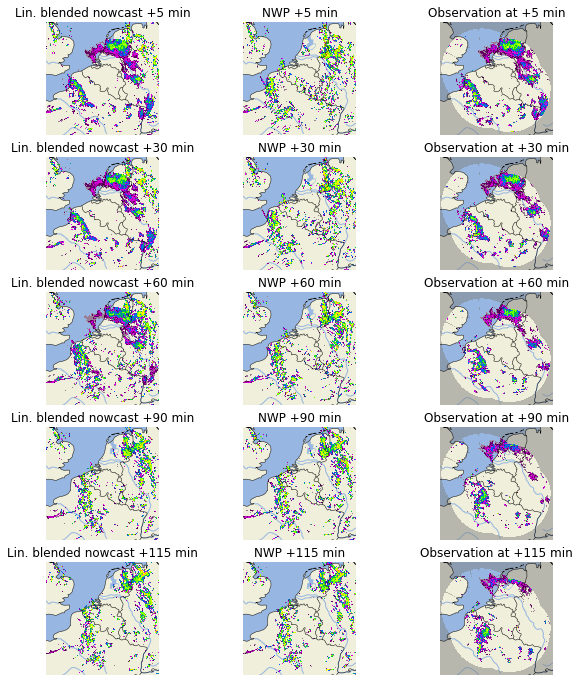

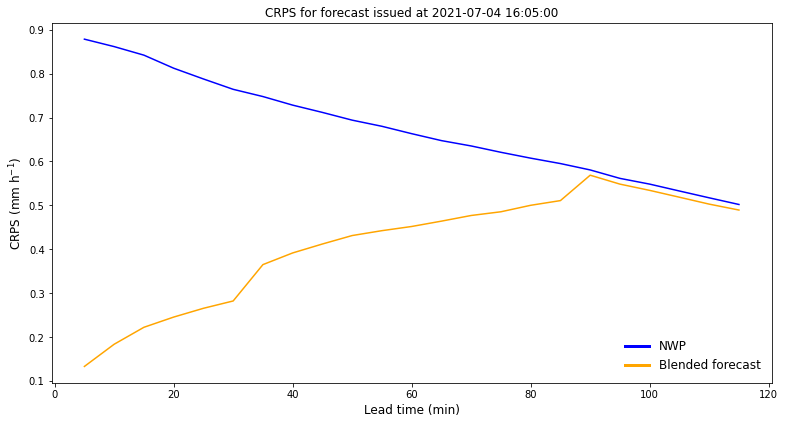

In [14]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 12))

leadtimes_min = [5, 30, 60, 90, 115]
n_leadtimes = len(leadtimes_min)
for n, leadtime in enumerate(leadtimes_min):

    # Nowcast with blending into NWP
    plt.subplot(n_leadtimes, 3, n * 3 + 1)
    plot_precip_field(
        precip_salient_blended[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Lin. blended nowcast +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 3, n * 3 + 2)
    plot_precip_field(
        nwp_precip[int(leadtime / timestep) - 1, :, :],
        geodata=nwp_metadata,
        title=f"NWP +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # The observed rainfall
    plt.subplot(n_leadtimes, 3, n * 3 + 3)
    plot_precip_field(
        precip_obs[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Observation at +{leadtime} min",
        axis="off",
        colorbar=False,
    )
    
# Determine the skill of both forecasts
# We will use the CRPS (but feel free to use any other skill score), as it allows
# us to do tests with ensemble forecasts later on.
# Make an empty list of the CRPS per lead time
CRPS_lt = dict({'blended': [], 'NWP': []})
n_timesteps = 23
for lt in range(n_timesteps):
    CRPS_lt['blended'].append(pysteps.verification.probscores.CRPS(np.stack([precip_salient_blended[lt,:,:]]),precip_obs[lt,:,:]))
    CRPS_lt['NWP'].append(pysteps.verification.probscores.CRPS(np.stack([nwp_precip[lt,:,:]]),precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['NWP'],
    color="blue",
)
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['blended'],
    color="orange",
)

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title(f"CRPS for forecast issued at {date_radar}")

# Set the legend
legend_elements_cmls = [Line2D([0], [0], color='blue', label="NWP", linewidth = 3),
                        Line2D([0], [0], color='orange', label="Blended forecast", linewidth = 3),]

ax1.legend(handles=legend_elements_cmls, loc='lower right', frameon = False, fontsize = 12, ncol = 1)

plt.tight_layout()
plt.show()


## STEPS blending

A disadvantage of the previous methods is that it requires the user to set the start and end time of the blending. The optimal times and blending weights are not known to the user in advance and can change from forecast to forecast. The [STEPS blending method](https://pysteps.readthedocs.io/en/latest/pysteps_reference/blending.html#pysteps-blending-steps) determines the blending weights and timing based on the initial and expected skill of the blending components, which are estimated from the recent and previous skill of the forecast components. The STEPS method, as you have already used for ensemble nowcasts in block 4 of this tutorial, makes it possible to perturb both the nowcast and NWP components on different spatial scale levels, which should lead to a better representation of the uncertainty in the (blended) forecast. 

### Pre-processing steps
Add a few more pre-processing steps on top of the pre-processing steps that have already been done.

In [15]:
# transform the data to dB
transformer = pysteps.utils.get_method("dB")
nwp_precip, nwp_metadata = transformer(nwp_precip, nwp_metadata, threshold=0.1)

# nwp_precip has to be four dimentional (n_models, time, y, x).
# If we only use one model (which is the case here):
if nwp_precip.ndim == 3:
    nwp_precip = nwp_precip[None, :]

### Determine the velocity field of the NWP forecast
We have already determined the velocity field of observed radar rainfall fields, but the STEPS blending procedure also requires the velocity field of the NWP forecast.

In [16]:
# Then for the NWP forecast
velocity_nwp = []
# Loop through the models
for n_model in range(nwp_precip.shape[0]):
    # Loop through the timesteps. We need two images to construct a motion
    # field, so we can start from timestep 1. Timestep 0 will be the same
    # as timestep 1.
    _v_nwp_ = []
    for t in range(1, nwp_precip.shape[1]):
        v_nwp_ = oflow_method(nwp_precip[n_model, t - 1 : t + 1, :])
        _v_nwp_.append(v_nwp_)
        v_nwp_ = None
    # Add the velocity field at time step 1 to time step 0.
    _v_nwp_ = np.insert(_v_nwp_, 0, _v_nwp_[0], axis=0)
    velocity_nwp.append(_v_nwp_)
velocity_nwp = np.stack(velocity_nwp)

### The STEPS blended forecast
We only run it with 1 ensemble member to keep run times quick.

In [17]:
precip_forecast_steps = pysteps.blending.steps.forecast(
    precip=radar_precip,
    precip_models=nwp_precip,
    velocity=velocity_radar,
    velocity_models=velocity_nwp,
    timesteps=23,
    timestep=timestep,
    issuetime=date_radar,
    n_ens_members=1,
    precip_thr=radar_metadata["threshold"],
    kmperpixel=radar_metadata["xpixelsize"] / 1000.0,
    noise_stddev_adj="auto",
    vel_pert_method=None,
)

STEPS blending

Inputs
------
forecast issue time:         2021-07-04T16:05:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      yes

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        23
ensemble size:               1
parallel threads:            1
number of cascade levels:    8
order of the AR(p) model:    2
precip. intensity threshold: -10

In [18]:
# Transform the data back into mm/h
precip_forecast_steps, _ = converter(precip_forecast_steps, radar_metadata)
nwp_precip, _ = converter(nwp_precip, nwp_metadata)

### Visualize the output and give an indication of the skill

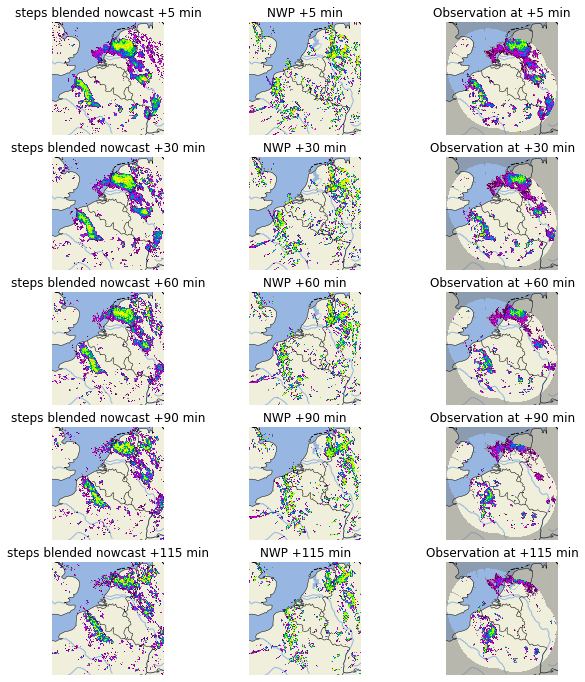

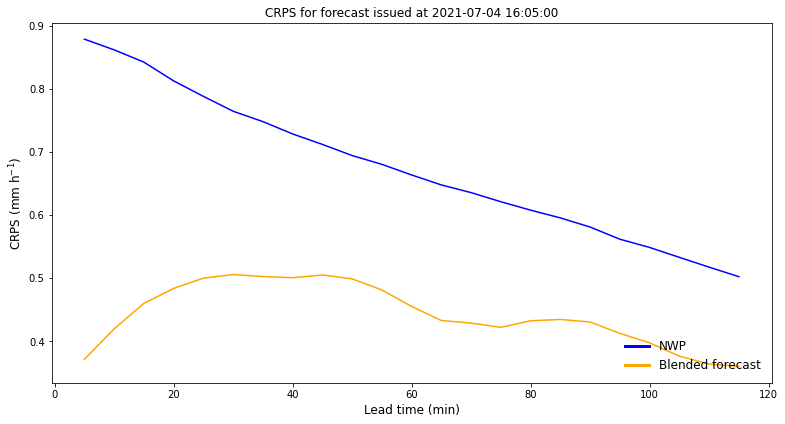

In [19]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 12))

leadtimes_min = [5, 30, 60, 90, 115]
n_leadtimes = len(leadtimes_min)
for n, leadtime in enumerate(leadtimes_min):

    # Nowcast with blending into NWP
    plt.subplot(n_leadtimes, 3, n * 3 + 1)
    plot_precip_field(
        precip_forecast_steps[0, int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"steps blended nowcast +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 3, n * 3 + 2)
    plot_precip_field(
        nwp_precip[0, int(leadtime / timestep) - 1, :, :],
        geodata=nwp_metadata,
        title=f"NWP +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # The observed rainfall
    plt.subplot(n_leadtimes, 3, n * 3 + 3)
    plot_precip_field(
        precip_obs[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Observation at +{leadtime} min",
        axis="off",
        colorbar=False,
    )
    
# Determine the skill of both forecasts
# We will use the CRPS (but feel free to use any other skill score), as it allows
# us to do tests with ensemble forecasts later on.
# Make an empty list of the CRPS per lead time
CRPS_lt = dict({'blended': [], 'NWP': []})
n_timesteps = 23
for lt in range(n_timesteps):
    CRPS_lt['blended'].append(pysteps.verification.probscores.CRPS(precip_forecast_steps[:,lt,:,:],precip_obs[lt,:,:]))
    CRPS_lt['NWP'].append(pysteps.verification.probscores.CRPS(nwp_precip[:,lt,:,:],precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['NWP'],
    color="blue",
)
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['blended'],
    color="orange",
)

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title(f"CRPS for forecast issued at {date_radar}")

# Set the legend
legend_elements_cmls = [Line2D([0], [0], color='blue', label="NWP", linewidth = 3),
                        Line2D([0], [0], color='orange', label="Blended forecast", linewidth = 3),]

ax1.legend(handles=legend_elements_cmls, loc='lower right', frameon = False, fontsize = 12, ncol = 1)

plt.tight_layout()
plt.show()